In [1]:
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
from logzero import logger
import sys

nthread = 8

def read_feather(name: str):
    logger.info("loading {}".format(name))
    df = pd.read_feather(name, nthreads=nthread).astype("float")
    logger.info(df.columns)
    return df

def show_top(var_names):
    print("{}{: >25}{}{: >12}{}".format('|','Variable Name','|','Memory','|'))
    print(" ------------------------------------ ")
    for var_name in var_names:
        memory = sys.getsizeof(eval(var_name))//1024//1024//1024
        if memory == 0:
            continue
        print("{}{: >25}{}{: >10}GB{}".format('|', var_name, '|', memory, '|'))

# Extract

小さいデータで学習して、データを間引く

In [2]:
ls -lha ../data/

total 217G
drwxrwxr-x 2 ubuntu ubuntu 4.0K May  2 12:51 ./
drwxrwxr-x 7 ubuntu ubuntu 4.0K Apr 27 18:29 ../
-rw-rw-r-- 1 ubuntu ubuntu 3.3G Apr 25 19:19 basic_table
-rw-rw-r-- 1 ubuntu ubuntu 850M Apr 25 19:19 channel_categorical
-rw-rw-r-- 1 ubuntu ubuntu 1.9G Apr 25 19:19 click_count_table
-rw-rw-r-- 1 ubuntu ubuntu 802M Apr 25 19:19 click_time_interval_ip_device_os_app_hash
-rw-rw-r-- 1 ubuntu ubuntu 706M Apr 26 07:28 down_sampling_train
-rw-rw-r-- 1 ubuntu ubuntu 3.2G Apr 25 19:19 intervals_table
-rw-rw-r-- 1 ubuntu ubuntu  10G Apr 25 19:19 misc_counts
-rw-rw-r-- 1 ubuntu ubuntu  16G Apr 25 19:19 multi_basic
-rw-rw-r-- 1 ubuntu ubuntu  12G Apr 25 21:45 next_prev_channels
-rw-r--r-- 1 ubuntu ubuntu  16G Apr 28 04:12 prev_next_click_basic
-rw-r--r-- 1 ubuntu ubuntu  31G Apr 28 05:27 prev_next_click_for_2_columns
-rw-r--r-- 1 ubuntu ubuntu  31G Apr 28 15:36 prev_next_click_for_3_columns
-rw-r--r-- 1 ubuntu ubuntu  19G Apr 29 12:27 prev_next_click_for_45_columns
-rw-rw-r-- 1 ubuntu ubu

In [3]:
prev_importances = [
 (1271, 'next_channel_by_device'),
 (1030, 'prev_channel_by_device'),
 (524, 'click_count_by_ip_os_device_dow_hour'),
 (522, 'second_of_day'),
 (487, 'ip_app_os_var'),
 (471, 'app'),
 (435, 'ip_dow_channel_var'),
 (410, 'channel'),
 (389, 'next_channel_by_ip_os'),
 (377, 'sin_of_day'),
 (373, 'cos_of_day'),
 (366, 'ip_app_count'),
 (353, 'device_app'),
 (351, 'click_count_by_ip'),
 (343, 'ip_app_channel_mean'),
 (332, 'ip_device_countuniq'),
 (332, 'click_time_interval_ip_device_os_app_hash'),
 (328, 'ip_app_countuniq'),
 (324, 'app_channel'),
 (321, 'ip_channel_countuniq'),
 (321, 'ip_app_os_countuniq'),
 (321, 'ip_app_channel_var'),
 (313, 'ip_device_os_app_countuniq'),
 (307, 'device_app_channel'),
 (307, 'click_time_interval_by_ip'),
 (299, 'click_count_by_ip_os_device_dow'),
 (297, 'next_channel_by_ip_os_device_app'),
 (292, 'rank_by_ip_os_device_dow'),
 (291, 'ip'),
 (278, 'next_channel_by_ip'),
 (273, 'app_channel_countuniq'),
 (272, 'ip_device_os_cumcount'),
 (258, 'ip_os'),
 (257, 'next_channel_by_ip_app'),
 (256, 'os'),
 (247, 'next_channel_by_ip_device'),
 (240, 'ip_dow_hour_count'),
 (235, 'next_channel_by_ip_os_device'),
 (229, 'ip_dow_hour_countuniq'),
 (228, 'minute'),
 (228, 'click_time_interval_by_ip_os_device'),
 (224, 'hour')]
prev_columns = [c for i, c in prev_importances]
prev_columns

['next_channel_by_device',
 'prev_channel_by_device',
 'click_count_by_ip_os_device_dow_hour',
 'second_of_day',
 'ip_app_os_var',
 'app',
 'ip_dow_channel_var',
 'channel',
 'next_channel_by_ip_os',
 'sin_of_day',
 'cos_of_day',
 'ip_app_count',
 'device_app',
 'click_count_by_ip',
 'ip_app_channel_mean',
 'ip_device_countuniq',
 'click_time_interval_ip_device_os_app_hash',
 'ip_app_countuniq',
 'app_channel',
 'ip_channel_countuniq',
 'ip_app_os_countuniq',
 'ip_app_channel_var',
 'ip_device_os_app_countuniq',
 'device_app_channel',
 'click_time_interval_by_ip',
 'click_count_by_ip_os_device_dow',
 'next_channel_by_ip_os_device_app',
 'rank_by_ip_os_device_dow',
 'ip',
 'next_channel_by_ip',
 'app_channel_countuniq',
 'ip_device_os_cumcount',
 'ip_os',
 'next_channel_by_ip_app',
 'os',
 'next_channel_by_ip_device',
 'ip_dow_hour_count',
 'next_channel_by_ip_os_device',
 'ip_dow_hour_countuniq',
 'minute',
 'click_time_interval_by_ip_os_device',
 'hour']

In [4]:
%%time

data_files = [
    "../data/basic_table",
    "../data/click_count_table",
    "../data/click_time_interval_ip_device_os_app_hash",
    "../data/intervals_table",
    "../data/misc_counts",
    "../data/multi_basic",
    "../data/next_prev_channels",
    "../data/prev_next_click_basic",
#     "../data/prev_next_click_for_2_columns",
#     "../data/prev_next_click_for_3_columns",
#     "../data/prev_next_click_for_45_columns",
    "../data/ranks_table",
    "../data/time_of_day",
    "../data/time_table",
]

dfs = []
for file in data_files:
    df = read_feather(file)
    dropping = [c for c in df.columns if c not in prev_columns]
    df.drop(columns=dropping, inplace=True)
    dfs.append(df)

[I 180502 14:13:30 <ipython-input-1-29f11ab86043>:14] loading ../data/basic_table
[I 180502 14:14:11 <ipython-input-1-29f11ab86043>:16] Index(['app', 'channel', 'click_id', 'device', 'ip', 'is_attributed', 'os'], dtype='object')
[I 180502 14:14:13 <ipython-input-1-29f11ab86043>:14] loading ../data/click_count_table
[I 180502 14:14:35 <ipython-input-1-29f11ab86043>:16] Index(['click_count_by_ip', 'click_count_by_ip_os_device_dow',
           'click_count_by_ip_os_device_dow_hour'],
          dtype='object')
[I 180502 14:14:37 <ipython-input-1-29f11ab86043>:14] loading ../data/click_time_interval_ip_device_os_app_hash
[I 180502 14:14:47 <ipython-input-1-29f11ab86043>:16] Index(['click_time_interval_ip_device_os_app_hash', 'first_click_interval_ip_device_os_app_hash'], dtype='object')
[I 180502 14:14:48 <ipython-input-1-29f11ab86043>:14] loading ../data/intervals_table
[I 180502 14:15:30 <ipython-input-1-29f11ab86043>:16] Index(['click_time_interval_by_ip', 'click_time_interval_by_ip_os_d

CPU times: user 1min 37s, sys: 2min 46s, total: 4min 24s
Wall time: 13min 12s


In [5]:
click_data = pd.concat(dfs, axis=1, copy=False)

In [6]:
del dfs
gc.collect()

105

In [7]:
show_top(dir())

|            Variable Name|      Memory|
 ------------------------------------ 
|               click_data|        63GB|
|                       df|         3GB|


In [8]:
click_data.columns

Index(['app', 'channel', 'ip', 'os', 'click_count_by_ip',
       'click_count_by_ip_os_device_dow',
       'click_count_by_ip_os_device_dow_hour',
       'click_time_interval_ip_device_os_app_hash',
       'click_time_interval_by_ip', 'click_time_interval_by_ip_os_device',
       'ip_device_os_cumcount', 'ip_channel_countuniq',
       'ip_dow_hour_countuniq', 'ip_app_countuniq', 'ip_app_os_countuniq',
       'ip_device_countuniq', 'app_channel_countuniq',
       'ip_device_os_app_countuniq', 'ip_dow_hour_count', 'ip_app_count',
       'ip_dow_channel_var', 'ip_app_os_var', 'ip_app_channel_var',
       'ip_app_channel_mean', 'ip_os', 'device_app', 'app_channel',
       'device_app_channel', 'next_channel_by_device',
       'prev_channel_by_device', 'next_channel_by_ip', 'next_channel_by_ip_os',
       'next_channel_by_ip_device', 'next_channel_by_ip_app',
       'next_channel_by_ip_os_device', 'next_channel_by_ip_os_device_app',
       'rank_by_ip_os_device_dow', 'second_of_day', 'sin_o

In [9]:
click_data["dow"] = read_feather("../data/time_table")["dow"]

[I 180502 14:31:30 <ipython-input-1-29f11ab86043>:14] loading ../data/time_table
[I 180502 14:31:33 <ipython-input-1-29f11ab86043>:16] Index(['dow', 'hour', 'minute', 'second'], dtype='object')


In [10]:
click_data = click_data[click_data["dow"] <= 3]

In [18]:
show_top(dir())

|            Variable Name|      Memory|
 ------------------------------------ 
|               click_data|        61GB|


In [17]:
del df

In [12]:
is_attributed = read_feather("../data/basic_table")[:click_data.shape[0]]

[I 180502 14:34:16 <ipython-input-1-29f11ab86043>:14] loading ../data/basic_table
[I 180502 14:34:56 <ipython-input-1-29f11ab86043>:16] Index(['app', 'channel', 'click_id', 'device', 'ip', 'is_attributed', 'os'], dtype='object')


In [13]:
click_data["is_attributed"] = is_attributed["is_attributed"]

In [14]:
del is_attributed
gc.collect()

7

In [15]:
click_data.to_feather("../data/tmp")

In [2]:
click_data = read_feather("../data/tmp")

[I 180502 13:57:55 <ipython-input-1-29f11ab86043>:14] loading ../data/tmp
[I 180502 14:07:42 <ipython-input-1-29f11ab86043>:16] Index(['app', 'channel', 'ip', 'os', 'click_count_by_ip',
           'click_count_by_ip_os_device_dow',
           'click_count_by_ip_os_device_dow_hour',
           'click_time_interval_ip_device_os_app_hash',
           'click_time_interval_by_ip', 'click_time_interval_by_ip_os_device',
           'ip_device_os_cumcount', 'ip_channel_countuniq',
           'ip_dow_hour_countuniq', 'ip_app_countuniq', 'ip_app_os_countuniq',
           'ip_device_countuniq', 'app_channel_countuniq',
           'ip_device_os_app_countuniq', 'ip_dow_hour_count', 'ip_app_count',
           'ip_app_os_count', 'ip_dow_channel_var', 'ip_app_os_var',
           'ip_app_channel_var', 'ip_app_channel_mean', 'ip_os_device_app_hash',
           'ip_os', 'device_app', 'app_channel', 'device_app_channel',
           'next_channel_by_device', 'prev_channel_by_device',
           'next_chann

In [ ]:
%%time
def do_train(df, day):
    logger.info("train started")
    train = df[df["dow"] != day]
    logger.info("train created")
    test = df[df["dow"] == day]
    logger.info("test created")
    
    y_train = train["is_attributed"].astype("int")
    train.drop(columns=["is_attributed"], inplace=True)
    test.drop(columns=["is_attributed"], inplace=True)
    gc.collect()
    
    logger.info("dropped")
    train = train.values
    gc.collect()
    
    logger.info("Generating matrix...")
    dtrain = xgb.DMatrix(train, y_train, nthread=nthread)
    del train, y_train
    gc.collect()
    
    logger.info("testing...")
    params = {'eta': 0.6,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,
          'max_depth': 0,
          'subsample': 0.9,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'min_child_weight': 0,
          'alpha': 4,
          'objective': 'binary:logistic',
          'scale_pos_weight': 9,
          'eval_metric': 'auc',
          'nthread': nthread,
          'random_state': 99,
          'silent': False}
    
    watchlist = [(dtrain, 'train')]
    model = xgb.train(params, dtrain, 15, watchlist, maximize=True, verbose_eval=1)
    del dtrain
    gc.collect()

    logger.info("Generating test matrix")
    test = xgb.DMatrix(test.values, nthread=nthread)
    gc.collect()
    
    return model.predict(test, ntree_limit=model.best_ntree_limit)
    
predicts = []
for day in range(4):
    logger.info("day {}".format(day))
    predicts.append(do_train(click_data, day))

[I 180502 14:48:44 <timed exec>:53] day 0
[I 180502 14:48:44 <timed exec>:2] train started
[I 180502 14:53:54 <timed exec>:4] train created
[I 180502 14:53:56 <timed exec>:6] test created
/home/ubuntu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ubuntu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
[I 180502 14:54:26 <timed exec>:13] dropped
[I 180502 14:54:26 <timed exec>:17] Generating matrix...
[I 180502 14:58:02 <tim

[0]	train-auc:0.971319
[1]	train-auc:0.973401
[2]	train-auc:0.975875
[3]	train-auc:0.978341
[4]	train-auc:0.980457
[5]	train-auc:0.98101
[6]	train-auc:0.982078
[7]	train-auc:0.982384
[8]	train-auc:0.982537
[9]	train-auc:0.983656
[10]	train-auc:0.984648
[11]	train-auc:0.98559
[12]	train-auc:0.985688
[13]	train-auc:0.985622
[14]	train-auc:0.985923


[I 180502 15:18:50 <timed exec>:45] Generating test matrix
[I 180502 15:18:56 <timed exec>:53] day 1
[I 180502 15:18:56 <timed exec>:2] train started
[I 180502 15:19:21 <timed exec>:4] train created
[I 180502 15:19:34 <timed exec>:6] test created
[I 180502 15:20:02 <timed exec>:13] dropped
[I 180502 15:20:02 <timed exec>:17] Generating matrix...
[I 180502 15:20:47 <timed exec>:22] testing...


[0]	train-auc:0.968843
[1]	train-auc:0.975119
[2]	train-auc:0.976101
[3]	train-auc:0.978401
[4]	train-auc:0.980212
[5]	train-auc:0.980661
[6]	train-auc:0.981355
[7]	train-auc:0.982051
[8]	train-auc:0.98253
[9]	train-auc:0.983299
[10]	train-auc:0.984378
[11]	train-auc:0.985384
[12]	train-auc:0.986058
[13]	train-auc:0.986484
[14]	train-auc:0.986055


[I 180502 15:36:09 <timed exec>:45] Generating test matrix
[I 180502 15:36:49 <timed exec>:53] day 2
[I 180502 15:36:49 <timed exec>:2] train started
[I 180502 15:37:14 <timed exec>:4] train created
[I 180502 15:37:27 <timed exec>:6] test created
[I 180502 15:37:55 <timed exec>:13] dropped
[I 180502 15:37:55 <timed exec>:17] Generating matrix...
[I 180502 15:38:41 <timed exec>:22] testing...


[0]	train-auc:0.960732
[1]	train-auc:0.971809
[2]	train-auc:0.974655
[3]	train-auc:0.976758
[4]	train-auc:0.977789
[5]	train-auc:0.978991


In [20]:
len(predicts)

4

In [21]:
predicts[0]

array([8.2362583e-04, 8.2676363e-04, 8.2676363e-04, ..., 2.9272158e-04,
       6.6526383e-01, 3.4567919e-02], dtype=float32)

In [24]:
predicts = np.concatenate(predicts, axis=0)

In [25]:
predicts

array([0.00082363, 0.00082676, 0.00082676, ..., 0.00263758, 0.00010159,
       0.00251996], dtype=float32)

In [26]:
is_attributed = read_feather("../data/basic_table")[["is_attributed"]]

[I 180502 18:34:20 <ipython-input-1-29f11ab86043>:14] loading ../data/basic_table
[I 180502 18:35:01 <ipython-input-1-29f11ab86043>:16] Index(['app', 'channel', 'click_id', 'device', 'ip', 'is_attributed', 'os'], dtype='object')


In [30]:
is_attributed = is_attributed[:len(predicts)]

In [32]:
is_attributed["prediction"] = predicts

/home/ubuntu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
is_attributed["abs"] = np.abs(is_attributed["is_attributed"] - is_attributed["prediction"])

/home/ubuntu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
is_attributed.drop(columns=["is_attributed"], inplace=True)

/home/ubuntu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
is_attributed.to_feather("../data/down_sampling_train")

In [40]:
is_attributed

,prediction,abs
0,0.000824,0.000824
1,0.000827,0.000827
2,0.000827,0.000827
3,0.000202,0.000202
4,0.003911,0.003911
5,0.004696,0.004696
6,0.000502,0.000502
7,0.000977,0.000977
8,0.001174,0.001174
9,0.001130,0.001130


# Validation

全特徴量でやっていく

In [4]:
state = np.random.RandomState(71)
down["random_sample"] = state.random_sample(down.shape[0])

In [31]:
down.to_feather("../data/down_sampling_train")

In [2]:
down = read_feather("../data/down_sampling_train")

[I 180504 00:23:31 <ipython-input-1-29f11ab86043>:14] loading ../data/down_sampling_train
[I 180504 00:23:34 <ipython-input-1-29f11ab86043>:16] Index(['prediction', 'abs', 'random_sample'], dtype='object')


In [3]:
ls -lha ../data/

total 155G
drwxrwxr-x 2 ubuntu ubuntu 4.0K May  2 18:37 ./
drwxrwxr-x 7 ubuntu ubuntu 4.0K Apr 27 18:29 ../
-rw-rw-r-- 1 ubuntu ubuntu 3.3G Apr 25 19:19 basic_table
-rw-rw-r-- 1 ubuntu ubuntu 850M Apr 25 19:19 channel_categorical
-rw-rw-r-- 1 ubuntu ubuntu 1.9G Apr 25 19:19 click_count_table
-rw-rw-r-- 1 ubuntu ubuntu 802M Apr 25 19:19 click_time_interval_ip_device_os_app_hash
-rw-rw-r-- 1 ubuntu ubuntu 4.2G May  3 23:50 down_sampling_train
-rw-rw-r-- 1 ubuntu ubuntu 3.2G Apr 25 19:19 intervals_table
-rw-rw-r-- 1 ubuntu ubuntu  10G Apr 25 19:19 misc_counts
-rw-rw-r-- 1 ubuntu ubuntu  16G Apr 25 19:19 multi_basic
-rw-rw-r-- 1 ubuntu ubuntu  12G Apr 25 21:45 next_prev_channels
-rw-r--r-- 1 ubuntu ubuntu  16G Apr 28 04:12 prev_next_click_basic
-rw-r--r-- 1 ubuntu ubuntu  31G Apr 28 05:27 prev_next_click_for_2_columns
-rw-r--r-- 1 ubuntu ubuntu  31G Apr 28 15:36 prev_next_click_for_3_columns
-rw-r--r-- 1 ubuntu ubuntu  19G Apr 29 12:27 prev_next_click_for_45_columns
-rw-rw-r-- 1 ubuntu ubu

In [4]:
sampling = (down["abs"] > 0.005) | (down["prediction"] + down["abs"] == 1.0) | (down["random_sample"] < 0.1)

In [5]:
%%time

data_files = [
    "../data/basic_table",
    "../data/click_count_table",
    "../data/click_time_interval_ip_device_os_app_hash",
    "../data/intervals_table",
    "../data/misc_counts",
    "../data/multi_basic",
    "../data/next_prev_channels",
    "../data/prev_next_click_basic",
    "../data/prev_next_click_for_2_columns",
    "../data/prev_next_click_for_3_columns",
    "../data/prev_next_click_for_45_columns",
    "../data/ranks_table",
    "../data/time_of_day",
    "../data/time_table",
]

click_data = pd.concat([read_feather(file)[:down.shape[0]][sampling] for file in data_files], axis=1, copy=False)

[I 180504 00:24:13 <ipython-input-1-29f11ab86043>:14] loading ../data/basic_table
[I 180504 00:24:27 <ipython-input-1-29f11ab86043>:16] Index(['app', 'channel', 'click_id', 'device', 'ip', 'is_attributed', 'os'], dtype='object')
[I 180504 00:24:31 <ipython-input-1-29f11ab86043>:14] loading ../data/click_count_table
[I 180504 00:24:52 <ipython-input-1-29f11ab86043>:16] Index(['click_count_by_ip', 'click_count_by_ip_os_device_dow',
           'click_count_by_ip_os_device_dow_hour'],
          dtype='object')
[I 180504 00:24:55 <ipython-input-1-29f11ab86043>:14] loading ../data/click_time_interval_ip_device_os_app_hash
[I 180504 00:25:05 <ipython-input-1-29f11ab86043>:16] Index(['click_time_interval_ip_device_os_app_hash', 'first_click_interval_ip_device_os_app_hash'], dtype='object')
[I 180504 00:25:07 <ipython-input-1-29f11ab86043>:14] loading ../data/intervals_table
[I 180504 00:25:49 <ipython-input-1-29f11ab86043>:16] Index(['click_time_interval_by_ip', 'click_time_interval_by_ip_os_d

CPU times: user 3min 17s, sys: 4min 7s, total: 7min 25s
Wall time: 25min 57s


In [6]:
%%time
logger.info("Splitting data...")
click_data.drop(columns=["click_id"], inplace=True)
logger.info("dropped")
train = click_data[click_data["dow"] < 3]
logger.info("created train")
valid = click_data[click_data["dow"] == 3]
logger.info("created valid")

del click_data
gc.collect()

y_train = train["is_attributed"].astype("int")
train.drop(columns=["is_attributed"], inplace=True)

y_valid = valid["is_attributed"].astype("int")
valid.drop(columns=["is_attributed"], inplace=True)
gc.collect()

[I 180504 00:50:22 <timed exec>:1] Splitting data...
[I 180504 00:50:39 <timed exec>:3] dropped
[I 180504 00:50:53 <timed exec>:5] created train
[I 180504 00:51:00 <timed exec>:7] created valid


CPU times: user 27 s, sys: 28.6 s, total: 55.6 s
Wall time: 55.4 s


In [7]:
%%time
logger.info("Generating matrix...")
dtrain = xgb.DMatrix(train, y_train)
logger.info("created train")
dvalid = xgb.DMatrix(valid, y_valid)
logger.info("created test")

del train, y_train, valid, y_valid
gc.collect()

[I 180504 00:51:18 <timed exec>:1] Generating matrix...
[I 180504 00:52:08 <timed exec>:3] created train
[I 180504 00:52:34 <timed exec>:5] created test


CPU times: user 45.6 s, sys: 30.6 s, total: 1min 16s
Wall time: 1min 16s


In [9]:
%%time
logger.info("Validating...")
params = {'eta': 0.6,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,
          'max_depth': 0,
          'subsample': 0.9,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'min_child_weight': 0,
          'alpha': 4,
          'objective': 'binary:logistic',
          'scale_pos_weight': 9,
          'eval_metric': 'auc',
          'nthread': nthread,
          'random_state': 99,
          'silent': False}
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params,
                  dtrain,
                  200,
                  watchlist,
                  maximize=True,
                  early_stopping_rounds=25,
                  verbose_eval=5)

[I 180504 00:53:15 <timed exec>:1] Validating...


[0]	train-auc:0.956481	valid-auc:0.940944
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.974153	valid-auc:0.956381
[10]	train-auc:0.982909	valid-auc:0.959181
[15]	train-auc:0.987207	valid-auc:0.956741
[20]	train-auc:0.990267	valid-auc:0.955106
[25]	train-auc:0.992593	valid-auc:0.953463
[30]	train-auc:0.994316	valid-auc:0.953654
[35]	train-auc:0.995619	valid-auc:0.954653
Stopping. Best iteration:
[10]	train-auc:0.982909	valid-auc:0.959181

CPU times: user 1h 22min 7s, sys: 0 ns, total: 1h 22min 7s
Wall time: 13min 7s


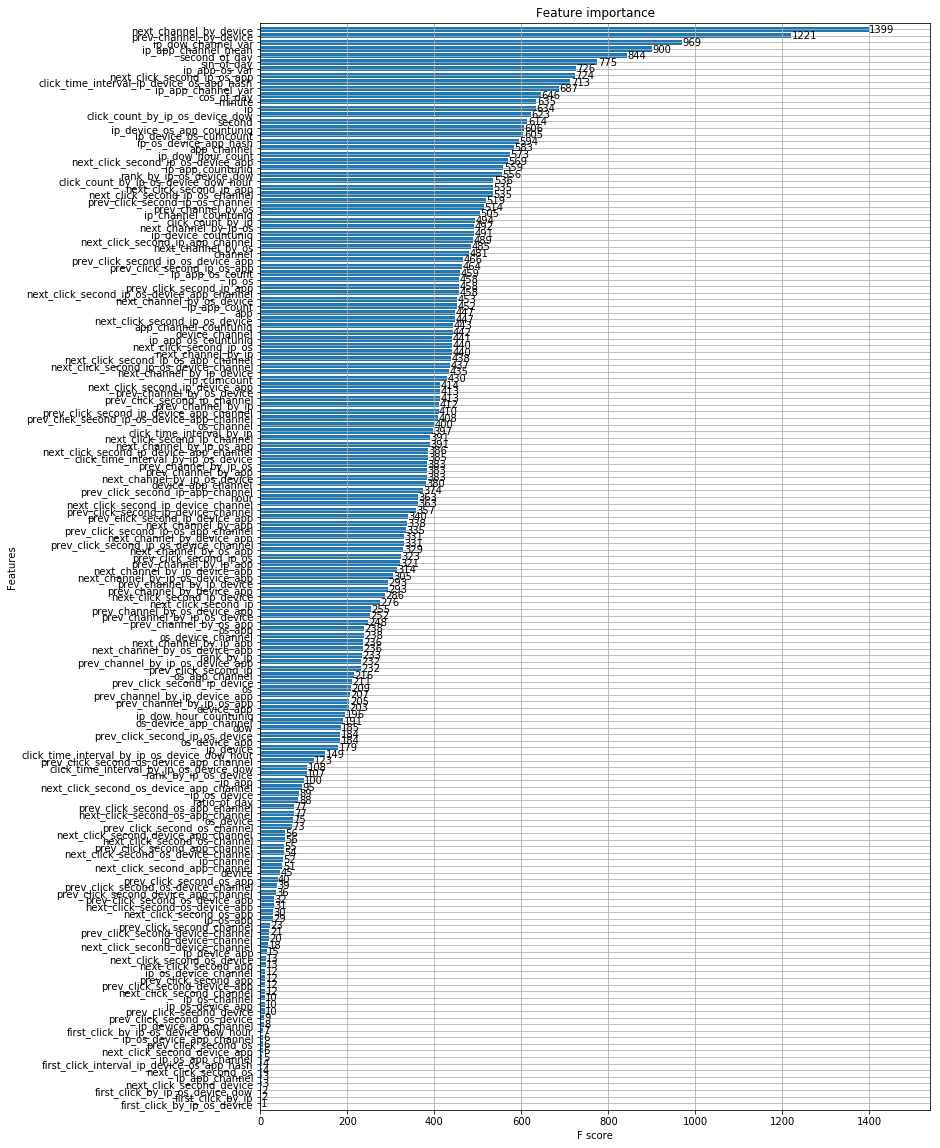

In [17]:
fig, ax = plt.subplots(figsize=(12,20))
xgb.plot_importance(model, max_num_features=200, height=0.8, ax=ax)
plt.show()

In [16]:
sorted_features = sorted([(value, key) for key, value in model.get_score().items()], reverse=True)
for importance, name in sorted_features:
    print(importance, name)

1399 next_channel_by_device
1221 prev_channel_by_device
969 ip_dow_channel_var
900 ip_app_channel_mean
844 second_of_day
775 sin_of_day
726 ip_app_os_var
724 next_click_second_ip_os_app
713 click_time_interval_ip_device_os_app_hash
687 ip_app_channel_var
646 cos_of_day
635 minute
634 ip
623 click_count_by_ip_os_device_dow
614 second
606 ip_device_os_app_countuniq
605 ip_device_os_cumcount
594 ip_os_device_app_hash
583 app_channel
573 ip_dow_hour_count
569 next_click_second_ip_os_device_app
559 ip_app_countuniq
556 rank_by_ip_os_device_dow
536 click_count_by_ip_os_device_dow_hour
535 next_click_second_ip_os_channel
535 next_click_second_ip_app
519 prev_click_second_ip_os_channel
514 prev_channel_by_os
505 ip_channel_countuniq
494 click_count_by_ip
492 next_channel_by_ip_os
491 ip_device_countuniq
489 next_click_second_ip_app_channel
485 next_channel_by_os
481 channel
466 prev_click_second_ip_os_device_app
464 prev_click_second_ip_os_app
459 ip_app_os_count
458 prev_click_second_ip_app
4

# Prediction

In [2]:
down = read_feather("../data/down_sampling_train")

[I 180504 12:34:35 <ipython-input-1-29f11ab86043>:14] loading ../data/down_sampling_train
[I 180504 12:35:12 <ipython-input-1-29f11ab86043>:16] Index(['prediction', 'abs', 'random_sample'], dtype='object')


In [3]:
sampling = (down["abs"] > 0.005) | (down["prediction"] + down["abs"] == 1.0) | (down["random_sample"] < 0.1)

In [12]:
total_size = read_feather("../data/time_of_day").shape[0]

[I 180504 12:38:19 <ipython-input-1-29f11ab86043>:14] loading ../data/time_of_day
[I 180504 12:38:29 <ipython-input-1-29f11ab86043>:16] Index(['second_of_day', 'ratio_of_day', 'sin_of_day', 'cos_of_day'], dtype='object')


In [13]:
total_size

203694359

In [6]:
sampling = sampling.values

In [7]:
sampling

array([False, False, False, ...,  True, False, False])

In [8]:
sampling.shape

(184903890,)

In [14]:
test_size = total_size - sampling.shape[0]

In [15]:
test_size

18790469

In [16]:
sampling = np.append(sampling, [True for _ in range(test_size)])

In [18]:
del down

In [19]:
show_top(dir())

|            Variable Name|      Memory|
 ------------------------------------ 


読み込み時だけでなんだかんだ 200 GB くらいメモリ使う

In [20]:
%%time

data_files = [
    "../data/basic_table",
    "../data/click_count_table",
    "../data/click_time_interval_ip_device_os_app_hash",
    "../data/intervals_table",
    "../data/misc_counts",
    "../data/multi_basic",
    "../data/next_prev_channels",
    "../data/prev_next_click_basic",
    "../data/prev_next_click_for_2_columns",
    "../data/prev_next_click_for_3_columns",
    "../data/prev_next_click_for_45_columns",
    "../data/ranks_table",
    "../data/time_of_day",
    "../data/time_table",
]

click_data = pd.concat([read_feather(file)[sampling] for file in data_files], axis=1, copy=False)

[I 180504 12:39:39 <ipython-input-1-29f11ab86043>:14] loading ../data/basic_table
[I 180504 12:40:20 <ipython-input-1-29f11ab86043>:16] Index(['app', 'channel', 'click_id', 'device', 'ip', 'is_attributed', 'os'], dtype='object')
[I 180504 12:40:24 <ipython-input-1-29f11ab86043>:14] loading ../data/click_count_table
[I 180504 12:40:46 <ipython-input-1-29f11ab86043>:16] Index(['click_count_by_ip', 'click_count_by_ip_os_device_dow',
           'click_count_by_ip_os_device_dow_hour'],
          dtype='object')
[I 180504 12:40:49 <ipython-input-1-29f11ab86043>:14] loading ../data/click_time_interval_ip_device_os_app_hash
[I 180504 12:40:59 <ipython-input-1-29f11ab86043>:16] Index(['click_time_interval_ip_device_os_app_hash', 'first_click_interval_ip_device_os_app_hash'], dtype='object')
[I 180504 12:41:02 <ipython-input-1-29f11ab86043>:14] loading ../data/intervals_table
[I 180504 12:41:44 <ipython-input-1-29f11ab86043>:16] Index(['click_time_interval_by_ip', 'click_time_interval_by_ip_os_d

CPU times: user 3min 24s, sys: 8min 15s, total: 11min 40s
Wall time: 29min 57s


In [21]:
%%time
logger.info("Splitting data...")
train = click_data[click_data["dow"] != 4]
logger.info("created train")
test = click_data[click_data["dow"] == 4]
logger.info("created test")

del click_data
gc.collect()

[I 180504 13:10:01 <timed exec>:1] Splitting data...
[I 180504 13:10:22 <timed exec>:3] created train
[I 180504 13:10:35 <timed exec>:5] created test


CPU times: user 19.3 s, sys: 15.7 s, total: 35 s
Wall time: 34.9 s


In [22]:
%%time
y_train = train["is_attributed"].astype("int")
train.drop(columns=["is_attributed", "click_id"], inplace=True)

test.drop(columns=["is_attributed", "click_id"], inplace=True)
gc.collect()

CPU times: user 12.5 s, sys: 15.3 s, total: 27.7 s
Wall time: 27.6 s


In [23]:
%%time
feature_names = train.columns
train = train.values
gc.collect()

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 27.8 ms


In [25]:
%%time
logger.info("Generating matrix...")
dtrain = xgb.DMatrix(train, y_train, feature_names=feature_names, nthread=nthread)
del train, y_train
gc.collect()

[I 180504 13:11:57 <timed exec>:1] Generating matrix...


CPU times: user 48 s, sys: 22.8 s, total: 1min 10s
Wall time: 39.4 s


In [26]:
%%time
logger.info("Validating...")
params = {'eta': 0.6,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,
          'max_depth': 0,
          'subsample': 0.9,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'min_child_weight': 0,
          'alpha': 4,
          'objective': 'binary:logistic',
          'scale_pos_weight': 9,
          'eval_metric': 'auc',
          'nthread': nthread,
          'random_state': 99,
          'silent': False}
watchlist = [(dtrain, 'train')]
model = xgb.train(params, dtrain, 11, watchlist, maximize=True, verbose_eval=True)

[I 180504 13:13:17 <timed exec>:1] Validating...


[0]	train-auc:0.95446
[1]	train-auc:0.961039
[2]	train-auc:0.965992
[3]	train-auc:0.967861
[4]	train-auc:0.969223
[5]	train-auc:0.97119
[6]	train-auc:0.973984
[7]	train-auc:0.976027
[8]	train-auc:0.97722
[9]	train-auc:0.978282
[10]	train-auc:0.979355
CPU times: user 40min 42s, sys: 0 ns, total: 40min 42s
Wall time: 7min 34s


In [27]:
del dtrain
gc.collect()

21

In [28]:
%%time
logger.info("Generating test matrix")
test = xgb.DMatrix(test, nthread=nthread)
gc.collect()

[I 180504 13:20:52 <timed exec>:1] Generating test matrix


CPU times: user 58.7 s, sys: 0 ns, total: 58.7 s
Wall time: 38.5 s


In [29]:
predicted = pd.concat([
    pd.read_feather("../data/basic_table"),
    pd.read_feather("../data/time_table"),
], axis=1)
predicted = predicted[predicted["dow"] == 4]
predicted = predicted[["click_id"]]

In [30]:
predicted['is_attributed'] = model.predict(test, ntree_limit=model.best_ntree_limit)
predicted.to_csv('xgb_sub.csv',index=False)

In [31]:
sorted([(value, key) for key, value in model.get_score(importance_type="weight").items()], reverse=True)

[(785, 'prev_channel_by_device'),
 (514, 'next_channel_by_device'),
 (331, 'app'),
 (271, 'ratio_of_day'),
 (268, 'app_channel'),
 (266, 'hour'),
 (260, 'ip_app_count'),
 (257, 'channel'),
 (250, 'ip_device_os_app_countuniq'),
 (246, 'app_channel_countuniq'),
 (242, 'sin_of_day'),
 (240, 'ip_device_countuniq'),
 (240, 'device_channel'),
 (228, 'next_click_second_ip_os_device_app'),
 (224, 'click_count_by_ip'),
 (209, 'click_count_by_ip_os_device_dow'),
 (208, 'ip_dow_channel_var'),
 (200, 'next_click_second_ip_os_device_app_channel'),
 (196, 'ip_cumcount'),
 (193, 'click_time_interval_ip_device_os_app_hash'),
 (189, 'device_app_channel'),
 (186, 'device_app'),
 (185, 'ip_app_countuniq'),
 (184, 'ip_app_os_var'),
 (183, 'second_of_day'),
 (174, 'click_time_interval_by_ip'),
 (170, 'ip_app_channel_mean'),
 (165, 'next_channel_by_ip_os_app'),
 (156, 'minute'),
 (155, 'ip_device_os_cumcount'),
 (154, 'ip_app_channel_var'),
 (152, 'cos_of_day'),
 (149, 'next_channel_by_os'),
 (148, 'next_cl

In [32]:
sorted([(value, key) for key, value in model.get_score(importance_type="gain").items()], reverse=True)

[(24124.831108799994, 'ip_device_os_app_countuniq'),
 (6845.392121148028, 'app'),
 (6038.367463636366, 'ip_channel_countuniq'),
 (4152.279229674795, 'app_channel_countuniq'),
 (3553.6245908333335, 'next_click_second_ip_os_device'),
 (3452.3371463035023, 'channel'),
 (3034.2256105882343, 'ip_dow_hour_countuniq'),
 (2660.435722857142, 'next_click_second_ip_device'),
 (2065.5495083333335, 'device'),
 (1273.2878358333342, 'device_channel'),
 (1240.6941083333334, 'prev_click_second_os_app'),
 (1195.625541964286, 'ip_app_os_countuniq'),
 (1181.8604027027025, 'ip_app_countuniq'),
 (1174.6743581712071, 'next_channel_by_device'),
 (1134.8502582010597, 'device_app_channel'),
 (994.4302488372095, 'next_click_second_ip_os'),
 (976.5902339552232, 'app_channel'),
 (849.6220135031833, 'prev_channel_by_device'),
 (730.4127077669901, 'next_channel_by_ip_os_device'),
 (670.127823333333, 'next_click_second_os_app_channel'),
 (629.7809580645159, 'device_app'),
 (595.3071206140355, 'next_click_second_ip_os